In [15]:
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# import GPyOpt
import GPy
import os
import matplotlib as mpl
import matplotlib.tri as tri
# import ternary
import pickle
import datetime
from collections import Counter
import matplotlib.ticker as ticker
# import pyDOE
import random
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
import matplotlib.font_manager as font_manager
import copy
from scipy.interpolate import splrep
from scipy.interpolate import interp1d

# Load materials dataset

In [16]:
# go to directory where datasets reside
# load a dataset
# dataset names = ['Crossed barrel', 'Perovskite', 'AgNP', 'P3HT', 'AutoAM']
dataset_name = './datasets/P3HT'
raw_dataset = pd.read_csv(dataset_name + '_dataset.csv')
feature_name = list(raw_dataset.columns)[:-1]
objective_name = list(raw_dataset.columns)[-1]

# Processing

In [17]:
ds = copy.deepcopy(raw_dataset) 
# only P3HT/CNT, Crossed barrel, AutoAM need this line; Perovskite and AgNP do not need this line.
#ds[objective_name] = -raw_dataset[objective_name].values

ds_grouped = ds.groupby(feature_name)[objective_name].agg(lambda x: x.unique().mean())
ds_grouped = (ds_grouped.to_frame()).reset_index()


In [18]:
# pool size
# total number of data in set
N = len(ds_grouped)
print(N)
# number of top candidates, currently using top 5% of total dataset size
n_top = int(math.ceil(N * 0.05))
print(n_top)
# the top candidates and their indicies
top_indices = list(ds_grouped.sort_values(objective_name).head(n_top).index)

178
9


# Load calculation results from framework

In [19]:
# Load ensemble calculation results from framework
# for 50 ensembles, they take some time to run
# we therefore provide sample results for BO algorithm GP_Matern52_LCB2
# please retrieve the following files from vis_demo_calc folder

import pickle as pkl

rf_ucb = np.load("/home/mzr19001/secondClone/5835-Final-Project/results_P3HT_RBF_NOARD_EI_Init10.npy", allow_pickle = True)
# Please replace the above line with the below code if you ran benchmarking framework on your own dataset and obtained results locally. .
# test_run_results = np.load('test_run.npy', allow_pickle = True) 
# TopCount_collection_GP_Matern52_LCB2 = test_run_results[3]
len(rf_ucb)

50

# Random baseline

In [20]:
def P_rand(nn):
    x_random = np.arange(nn)
    
    M = n_top
    N = nn
    
    P = np.array([None for i in x_random])
    E = np.array([None for i in x_random])
    A = np.array([None for i in x_random])
    cA = np.array([None for i in x_random])
    
    P[0] = M / N
    E[0] = M / N
    A[0] = M / N
    cA[0] = A[0]
    

    for i in x_random[1:]:
        P[i] = (M - E[i-1]) / (N - i)
        E[i] = np.sum(P[:(i+1)])
        j = 0
        A_i = P[i]
        while j < i:
            A_i *= (1 - P[j])
            j+=1
        A[i] = A_i
        cA[i] = np.sum(A[:(i+1)])
        
    return E / M, cA

# Aggregation of performance

In [21]:
seed_list = [5782, 5776, 9975, 4569, 8020, 363, 9656, 992, 348, 6048, 4114, 7476, 4892, 9710, 9854, 5243, 
             2906, 5963, 3035, 5122, 9758, 4327, 4921, 6179, 1718, 441, 9326, 2153, 5079, 8192, 3646, 4413, 
             3910, 5370, 3070, 7130, 1589, 1668, 9842, 5275, 5468, 3677, 7183, 2773, 1309, 5516, 3572, 9312, 
             7390, 4433, 3686, 1981, 555, 8677, 3126, 5163, 9418, 3007, 4564, 5572, 1401, 5657, 9658, 2124, 
             6902, 4783, 8493, 4442, 7613, 5674, 6830, 4757, 6877, 9311, 6709, 582, 6770, 2555, 3269, 76, 
             7820, 8358, 7116, 9156, 3638, 529, 7482, 8503, 4735, 8910, 5588, 3726, 1115, 9644, 4702, 1966, 
             4006, 738, 575, 8393]

def aggregation_(seed, n_runs, n_fold):
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
    random.seed(seed)
    
    index_runs = list(np.arange(n_runs))
    
    agg_list = []
    
    i = 0
    
    while i < n_fold:
    
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
            
        agg_list.append(index_i)
        
        i += 1
#     print(agg_list)    
    return agg_list

def avg_(x):
#     nsteps
    n_eval = len(x[0]) 
    
#     fold
    n_fold = 5
    
#     rows = # of ensembles = 50
    n_runs = len(x)
    
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    
#     # of seeds 
    n_sets = len(seed_list)
    
    l_index_list = []
    
    for i in np.arange(n_sets):
        
        s = aggregation_(seed_list[i], n_runs, n_fold)
        l_index_list.extend(s)

#     rows in l_index_list

    assert len(l_index_list) == n_sets * n_fold

    
    l_avg_runs = []

    for i in np.arange(len(l_index_list)):
        
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            
            avg_run += np.array(x[j])
            
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    

    assert n_eval == len(l_avg_runs[0])
    assert n_sets * n_fold == len(l_avg_runs)
    
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    

#     5th, 95th percentile, mean, median are all accessible
    for i in np.arange(len(l_avg_runs[0])):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.05, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.95, out=None, overwrite_input=False, interpolation='linear')
    
    return np.array(median_), np.array(low_q), np.array(high_q), np.array(mean_), np.array(std_)

# Top%

In [22]:
def TopPercent(x_top_count, n_top, N):
    
    x_ = [[] for i in np.arange(len(x_top_count))]
    
    for i in np.arange(len(x_top_count)):
        for j in np.arange(N):
            if j < len(x_top_count[i]):
                x_[i].append(x_top_count[i][j] / n_top)
            else:
                x_[i].append(1)

    return x_


    

In [23]:
# Aggregating the performance
rf_ucb = avg_(TopPercent(rf_ucb, n_top, N))

 <>:29: SyntaxWarning:invalid escape sequence '\m'
 <>:29: SyntaxWarning:invalid escape sequence '\m'
 <>:29: SyntaxWarning:invalid escape sequence '\m'
 <>:29: SyntaxWarning:invalid escape sequence '\m'
 /tmp/ipykernel_2574625/705609966.py:29: SyntaxWarning:invalid escape sequence '\m'
 /tmp/ipykernel_2574625/705609966.py:29: SyntaxWarning:invalid escape sequence '\m'


([<matplotlib.axis.YTick at 0x71fd642db800>,
 [Text(0, 0.0, '0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


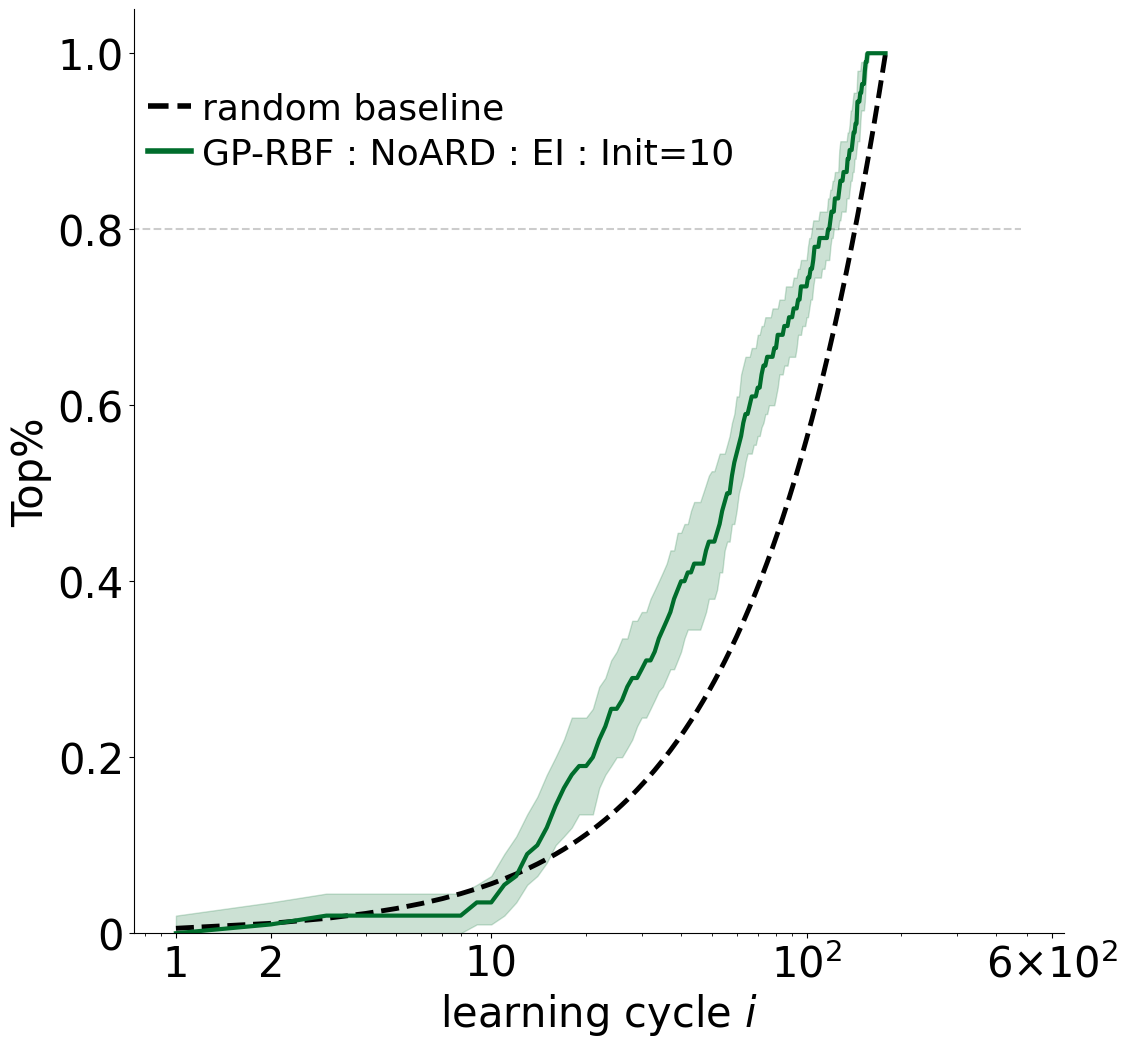

In [24]:
fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

ax0.plot(np.arange(N)+1, P_rand(N)[0],'--',color='black',label='random baseline', linewidth=3.5)

ax0.plot(np.arange(N) + 1, np.round(rf_ucb[0].astype(np.double) / 0.005, 0) * 0.005, label = 'GP-RBF : NoARD : EI : Init=10', color = '#006d2c', linewidth=3)
ax0.fill_between(np.arange(N) + 1, np.round(rf_ucb[1].astype(np.double) / 0.005, 0) * 0.005, np.round(rf_ucb[2].astype(np.double) / 0.005, 0) * 0.005, color = '#006d2c', alpha=0.2)

# ax0.plot(np.arange(N) + 1, np.round(RBF_UCB[0].astype(np.double) / 0.005, 0) * 0.005, label = 'GP RBF : UCB', color = '#08519c', linewidth=3)
# ax0.fill_between(np.arange(N) + 1, np.round(RBF_UCB[1].astype(np.double) / 0.005, 0) * 0.005, np.round(RBF_UCB[2].astype(np.double) / 0.005, 0) * 0.005, color = '#08519c', alpha=0.2)

# ax0.plot(np.arange(N) + 1, np.round(RBF_LogEI[0].astype(np.double) / 0.005, 0) * 0.005, label = 'GP RBF : LogEI', color = '#a50f15', linewidth=3)
# ax0.fill_between(np.arange(N) + 1, np.round(RBF_LogEI[1].astype(np.double) / 0.005, 0) * 0.005, np.round(RBF_LogEI[2].astype(np.double) / 0.005, 0) * 0.005, color = '#a50f15', alpha=0.2)

# the rest are for visualization purposes, please adjust for different needs
font = font_manager.FontProperties(family='Arial', size = 26, style='normal')
leg = ax0.legend(prop = font, borderaxespad = 0,  labelspacing = 0.3, handlelength = 1.2, handletextpad = 0.3, frameon=False, loc = (0, 0.81))
for line in leg.get_lines():
    line.set_linewidth(4)
ax0.set_ylabel("Top%", fontname="Arial", fontsize=30, rotation='vertical')    
plt.hlines(0.8, 0, 480, colors='k', linestyles='--', alpha = 0.2)
ax0.set_ylim([0, 1.05])
ax0.set_xscale('log')
ax0.set_xlabel('learning cycle $i$', fontsize=30, fontname = 'Arial')
ax0.xaxis.set_tick_params(labelsize=30)
ax0.yaxis.set_tick_params(labelsize=30)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
plt.xticks([1, 2, 10, 100, 600], ['1', '2','10', '10$^{\mathrm{2}}$', '6$×$10$^{\mathrm{2}}$'],fontname = 'Arial')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontname = 'Arial')

# Enhancement Factor

In [25]:
def EF(x):
    n_eval = len(x)
    TopPercent_RS = P_rand(n_eval)[0]
    
    l_EF = []
    for j in np.arange(n_eval):
        l_EF.append(x[j] / TopPercent_RS[j])
        
    return l_EF




 <>:27: SyntaxWarning:invalid escape sequence '\m'
 <>:27: SyntaxWarning:invalid escape sequence '\m'
 <>:27: SyntaxWarning:invalid escape sequence '\m'
 <>:27: SyntaxWarning:invalid escape sequence '\m'
 /tmp/ipykernel_2574625/1916659538.py:27: SyntaxWarning:invalid escape sequence '\m'
 /tmp/ipykernel_2574625/1916659538.py:27: SyntaxWarning:invalid escape sequence '\m'
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: F

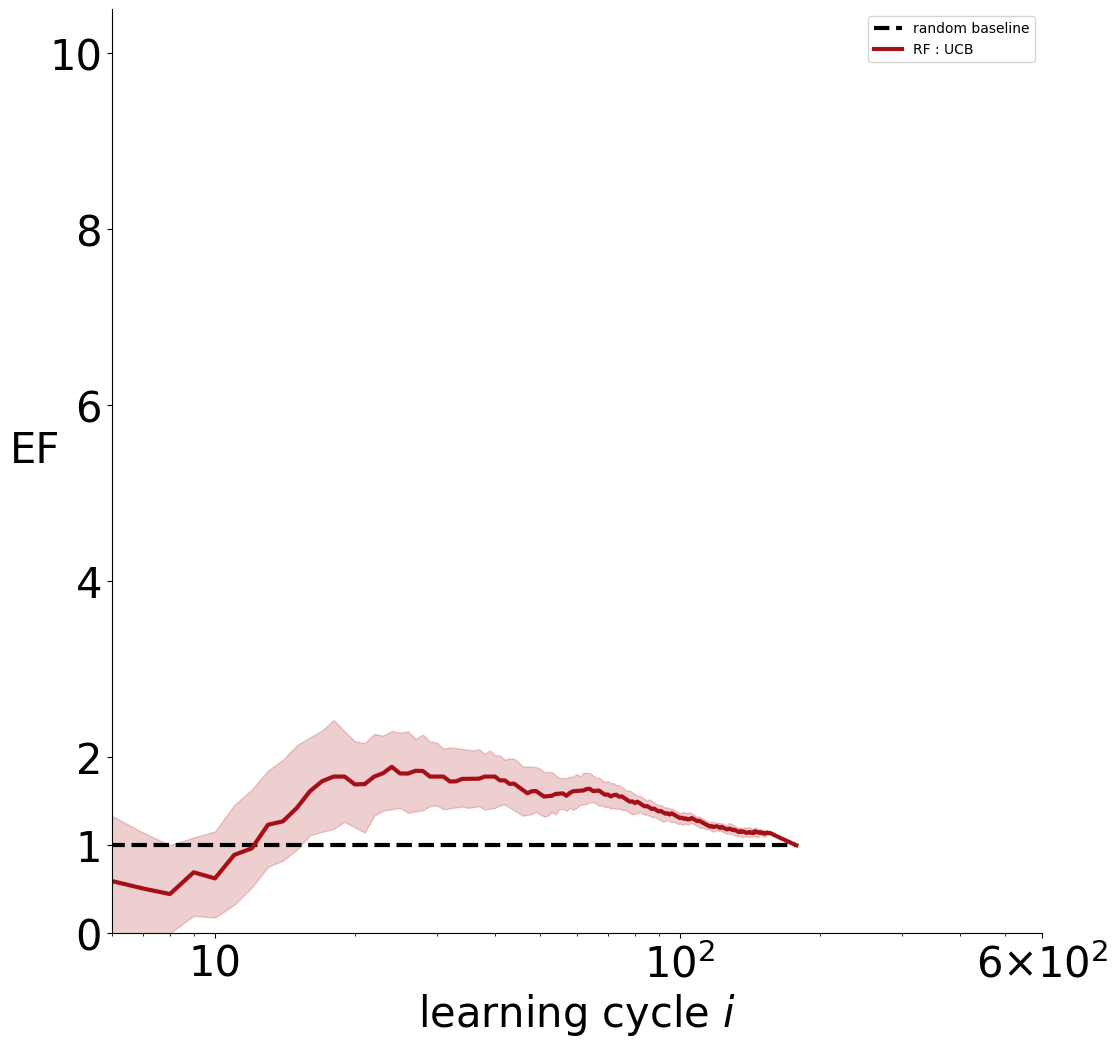

In [26]:
fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

ax0.plot(np.linspace(1, N, N), np.ones(N),'--',color='black',label='random baseline', linewidth = 3)        

#ax0.plot(np.arange(N) + 1, EF(np.round(rf_ucb[0].astype(np.double) / 0.005, 0) * 0.005), label = 'GP RBF : QEI', color = '#006d2c', linewidth=3, )
#ax0.fill_between(np.arange(N) + 1, EF(np.round(RBF_QEI[1].astype(np.double) / 0.005, 0) * 0.005), EF(np.round(RBF_QEI[2].astype(np.double) / 0.005, 0) * 0.005), color = '#006d2c', alpha=0.2)

#ax0.plot(np.arange(N) + 1, EF(np.round(RBF_UCB[0].astype(np.double) / 0.005, 0) * 0.005), label = 'GP RBF : UCB', color = '#08519c', linewidth=3)
#ax0.fill_between(np.arange(N) + 1, EF(np.round(RBF_UCB[1].astype(np.double) / 0.005, 0) * 0.005), EF(np.round(RBF_UCB[2].astype(np.double) / 0.005, 0) * 0.005), color = '#08519c', alpha=0.2, )


ax0.plot(np.arange(N) + 1, EF(np.round(rf_ucb[0].astype(np.double) / 0.005, 0) * 0.005), label = 'RF : UCB', color = '#a50f15', linewidth=3)
ax0.fill_between(np.arange(N) + 1, EF(np.round(rf_ucb[1].astype(np.double) / 0.005, 0) * 0.005), EF(np.round(rf_ucb[2].astype(np.double) / 0.005, 0) * 0.005), color = '#a50f15', alpha=0.2)

# the rest are for visualization purposes, please adjust for different needs

ax0.set_ylabel('EF', fontsize=30, rotation = 'horizontal', fontname = 'Arial', labelpad = 10)
ax0.set_xlabel('learning cycle $i$', fontsize=30, fontname = 'Arial')
ax0.set_xlim([6, 600])
ax0.set_ylim([0, 10.5])
ax0.set_xscale('log')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.xaxis.set_tick_params(labelsize=30)
ax0.yaxis.set_tick_params(labelsize=30)
plt.xticks([10, 100, 600], ['10', '10$^{\mathsf{2}}$', '6$×$10$^{\mathsf{2}}$'],fontname = 'Arial')
plt.yticks([0, 1, 2, 4, 6, 8, 10], ['0', '1', '2', '4', '6', '8', '10'], fontname = 'Arial')
plt.legend()
plt.show()

# Acceleration Factor

In [27]:
def AF(x):
    n_eval = len(x)
    TopPercent_RS = list(np.round(P_rand(n_eval)[0].astype(np.double) / 0.005, 0) * 0.005)
#     We check Top% at 0.005 intervals between 0 and 1.
    l_TopPercent = []
    l_AF = []
    
    x = list(np.round(x.astype(np.double) / 0.005, 0) * 0.005)
    
    TopPercent = np.arange(0, 1.005, 0.005)
    
    pointer_x = 0
    pointer_rs = 0
    for t in TopPercent:
        if t in x and t in TopPercent_RS:
            n_x = 0
            n_rs = 0
            while pointer_x < len(x):
                if x[pointer_x] == t:
                    pointer_x += 1
                    n_x = pointer_x
                    break
                else:
                    pointer_x += 1

            while pointer_rs < len(TopPercent_RS):
                if TopPercent_RS[pointer_rs] == t:
                    pointer_rs += 1
                    n_rs = pointer_rs
                    break
                else:
                    pointer_rs += 1
        
            l_TopPercent.append(t)
            
            AF = n_rs / n_x
            l_AF.append(AF)  
        
    return l_TopPercent, l_AF

# smoothing for visualization purposes
def AF_interp1d(TopPercent):
    f_med = interp1d(AF(TopPercent[0])[0], AF(TopPercent[0])[1], kind = 'linear', fill_value='extrapolate')
#     again 0.005 intervals
    xx_ = np.linspace(min(AF(TopPercent[0])[0]), 1, 201 - int(min(AF(TopPercent[0])[0])/0.005))
    f_low = interp1d(AF(TopPercent[1])[0], AF(TopPercent[1])[1], kind = 'linear', fill_value='extrapolate')
    f_high = interp1d(AF(TopPercent[2])[0], AF(TopPercent[2])[1], kind = 'linear', fill_value='extrapolate')   
    return xx_, f_med, f_low, f_high

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

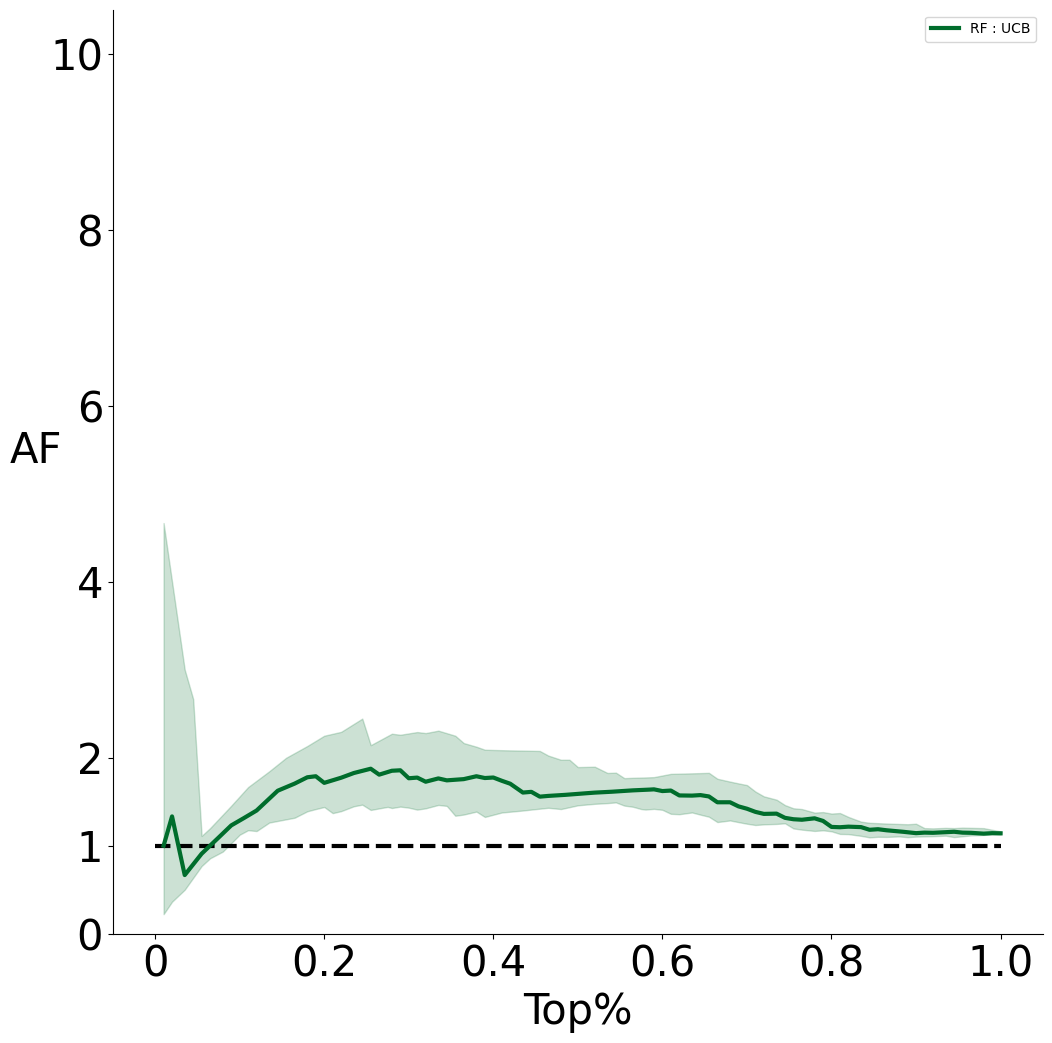

In [28]:
fig = plt.figure(figsize=(12,12))
ax0 = fig.add_subplot(111)

ax0.plot(np.linspace(0, 1, 200), np.ones(200),'--',color='black',label=None, linewidth=3)        


xx_, f_med_, f_low_, f_high_ = AF_interp1d(rf_ucb)
ax0.plot(xx_, f_med_(xx_), label = 'RF : UCB', color = '#006d2c', linewidth=3)
ax0.fill_between(xx_, f_low_(xx_), f_high_(xx_), color = '#006d2c', alpha=0.2)

#xx_, f_med_, f_low_, f_high_ = AF_interp1d(RBF_UCB)
#ax0.plot(xx_, f_med_(xx_), label = 'GP RBF : UCB', color = '#08519c', linewidth=3)
#ax0.fill_between(xx_, f_low_(xx_), f_high_(xx_), color = '#08519c', alpha=0.2)


#xx_, f_med_, f_low_, f_high_ = AF_interp1d(RBF_LogEI)
#ax0.plot(xx_, f_med_(xx_), label = 'GP RBF : LogEI', color = '#a50f15', linewidth=3)
#ax0.fill_between(xx_, f_low_(xx_), f_high_(xx_), color = '#a50f15', alpha=0.2)


# the rest are for visualization purposes, please adjust for different needs
ax0.set_ylabel('AF', fontsize = 30, rotation = 'horizontal', fontname = 'Arial', labelpad = 10)
ax0.set_xlabel('Top%', fontsize = 30, fontname = 'Arial')
ax0.set_ylim([0, 10.5])
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax0.xaxis.set_tick_params(labelsize=30)
ax0.yaxis.set_tick_params(labelsize=30)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontname = 'Arial')
plt.yticks([0, 1, 2, 4, 6, 8, 10], ['0', '1', '2', '4', '6', '8', '10'], fontname = 'Arial')
plt.legend()